# Google Trends analytics using Python
- Here we will be analyzing the Google search trends on the queries of our intered {You will get a chance to provide input}.

In [ ]:
#!pip install pytrends

***Start with importing libraries.***
---
*Probably need to run "pip install pytrends"*

In [233]:
# import necessary libaries
import pandas as pd
import numpy as np

from pytrends.request import TrendReq

import matplotlib.pyplot as plt
import seaborn as sns
from seaborn import load_dataset

import warnings
warnings.filterwarnings("ignore")

import re
from textblob import TextBlob
from wordcloud import WordCloud

from spacy.lang.en.stop_words import STOP_WORDS as en_stop #stopwords in English
from spacy.lang.da.stop_words import STOP_WORDS as da_stop #stopwords in Danish
final_stopwords= en_stop.union(da_stop)

# Connect to google and Build Payload
> The build_payload method from Pytrends is used to build a list of keywords that want to search in Google Trends. Can also specify the timeframe to gather data and the category to query the data from.
---
*kw_list:* list of the target search terms 

*cat:* Category to narrow result fx. Art, Entertainment.[link for category](https://github.com/pat310/google-trends-api/wiki/Google-Trends-Categories)

*timeframe:* Date to start from fx. Defaults to last 5yrs is 'today 5-y' or Everything is 'all'

*geo:* Location of interest represent by two letter country abbreviation fx. United States is 'US' or Defaults to World

*gprop:* What Google property to filter to fx. "image" or "news" default to web searches

In [515]:
# Function for connecting google and build playload
def pytrends_func(kw_list, timeframe):
  # Configuring connection wich receives two important parameters; hl (hosting language) & tz (timezone).
  trends = TrendReq(hl='en-US', tz= 360, timeout=(10,25))
  
  # Update playload
  trends.build_payload(kw_list=kw_list, cat=0, timeframe=timeframe, geo= '', gprop='') #timeframe='today 5-y'
  
  # return the trends object
  return trends

kw_list = ["Healthy food", "Healthy diet"] 
trends= pytrends_func(kw_list, 'today 12-m')
trends

# What kind of data want to pull? possible methods are:
- ***Interest Over Time:*** returns historical, indexed data for when the keyword was searched
- Historical Hourly Interest:  returns historical, indexed, hourly data for when the keyword was searched
- ***Interest by Region:*** returns data for where the keyword is most searched
- Related Topics: returns data for the related keywords to a provided keyword
- Related Queries: returns data for the related keywords to a provided keyword
- ***Trending Searches:*** returns data for latest trending searches
- Top Charts: returns the data for a given topic
- Suggestions: returns a list of additional suggested keywords that can be used to refine a trend search.

In [558]:
# Function to Disply in the figure
def display_lineplot(df, x, kw_list, title, x_label, y_label):
    """ The function will take x & value including title, x_label & y_label then display the figure"""
    fig, ax = plt.subplots(figsize= (10, 5))  # Create a figure containing a single axes. Alt-figsize= (10, 5)#, layout='constrained'
    
    # loop over columns to dorw line-plot and add to the figure
    for col in kw_list:
      ax.plot(df[x], df[col], label = col)

    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.xticks(rotation=45)
    plt.legend()  # Add a legend.
    plt.show()

def display_barplot(df, x_col, kw_list, title):
  fig, ax = plt.subplots(figsize= (10, 5))

  # loop over columns to dorw line-plot and add to the figure
  for col in kw_list:
    ax.bar(df[x_col], df[col], label= col)#, color ='blue', width = 0.4

  plt.title(title, fontsize=12)
  plt.xticks(rotation=45)
  plt.xlabel(x_col)
  plt.ylabel("Values")
  plt.show()

***Interest Over Time***

,date,Healthy food,Healthy diet
129,2022-09-27 09:00:00,54,16
130,2022-09-27 10:00:00,54,15
131,2022-09-27 11:00:00,56,16
132,2022-09-27 12:00:00,67,17
133,2022-09-27 13:00:00,68,21


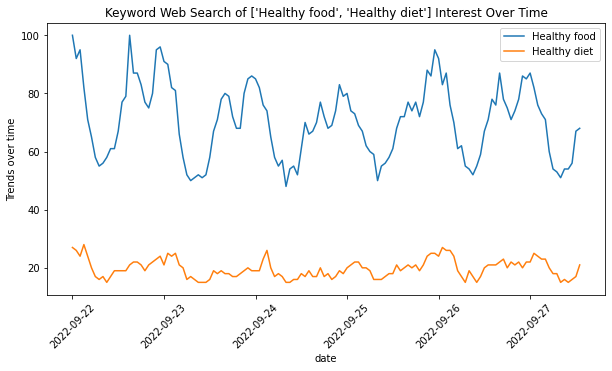

In [519]:
# function to extract interest over time
def gt_trends_over_time():
  # Interest Over Time
  data_over_time= trends.interest_over_time().drop(columns='isPartial')
  data_over_time = data_over_time.reset_index(drop=False)
  return data_over_time

display(gt_trends_over_time().tail())
data_over_time= gt_trends_over_time()

# Disply figure as lineplot
display_lineplot(data_over_time, "date", ["Healthy food", "Healthy diet"], title= f'Keyword Web Search of {kw_list} Interest Over Time', x_label= "date", y_label="Trends over time")

**Historical Hourly Interest**

,date,Healthy food,Healthy diet
0,2022-09-01 00:00:00,70,10
1,2022-09-01 01:00:00,56,0
2,2022-09-01 02:00:00,64,24
3,2022-09-01 03:00:00,26,16
4,2022-09-01 04:00:00,54,8


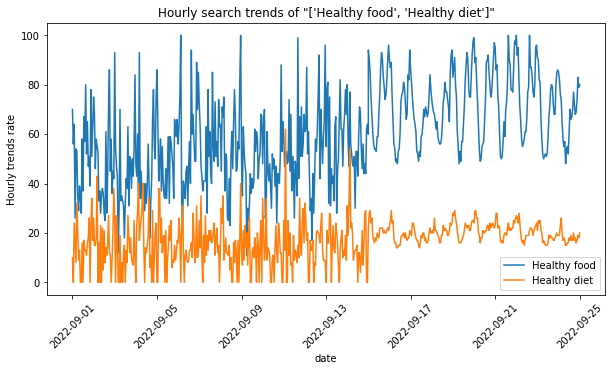

In [518]:
# Function for Historical hourly interest
def gt_hh_trends():
  # Historical Hourly Interest (The hourly interest of the keyword)
  hourly_trends= trends.get_historical_interest(kw_list, year_start=2022, month_start=9, day_start=1, hour_start=0, year_end=2022, month_end=9, day_end=25, hour_end=0, cat=0, sleep=0)
  hourly_trends = hourly_trends.reset_index().drop(columns='isPartial')
  return hourly_trends[hourly_trends[kw_list[0]]> 0]

data_hourly_trends=gt_hh_trends()
display(data_hourly_trends.head())

# Disply figure as lineplot
display_lineplot(data_hourly_trends, "date", ["Healthy food", "Healthy diet"], title= f'Hourly search trends of "{kw_list}"', x_label= "date", y_label="Hourly trends rate")


**Interest by Region(Search by geographical region)**

To show you which countries search the keyword on a scale of 0 to 100, where 100 represents a country with the most search

*The resolution value is dependent on the geo parameter of the common configuration:*

*Use resolution='COUNTRY' for geo='World'*

*Use resolution='REGION' for geo='US', Two letter country abbreviation. for example*

*gprop= What Google property to filter to.Can be `images, news, youtube or froogle`*

,geoName,Healthy food,Healthy diet
0,France,94,6
1,Indonesia,88,12
2,Singapore,88,12
3,Thailand,88,12
4,Sri Lanka,86,14
5,Mexico,85,15
6,Spain,84,16
7,Nepal,84,16
8,Netherlands,83,17
9,Germany,83,17


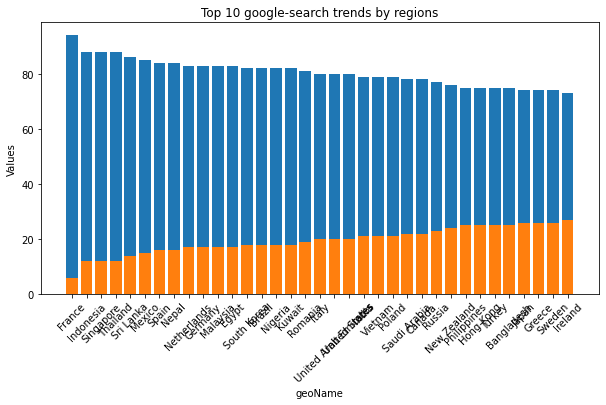

In [561]:
# Function for interest by region
def gt_trends_byregion():
  #trends= pytrends_func(["Healthy diet"], 'today 12-m', geo='', gprop='')
  # resolution can be either CITY, COUNTRY or REGION
  trends_by_region= trends.interest_by_region(resolution= 'COUNTRY', inc_low_vol=False, inc_geo_code=False)
  trends_by_region = trends_by_region.sort_values(by=kw_list[0], ascending=False).reset_index() #.sort_values('Likes', ascending=False, ignore_index=True)
  return trends_by_region

df_byregion= gt_trends_byregion()
display(df_byregion.head(30))

display_barplot(df_byregion.iloc[:35,:], "geoName", ["Healthy food", "Healthy diet"], "Top 10 google-search trends by regions")

**Related Queries**

In [527]:
#function for releted queries
def gt_related_queries():
  trends= gt_playload()
  # Related Queries (keywords that are closely tied to a primary keyword of the choice)
  related_queries= trends.related_queries()
  return related_queries[kw_list[0]]['top']

releted_queries=gt_related_queries()
releted_queries.head()

,query,value
0,healthy food near me,100
1,food near me,99
2,what is healthy food,54
3,eat healthy food,46
4,best healthy food,37


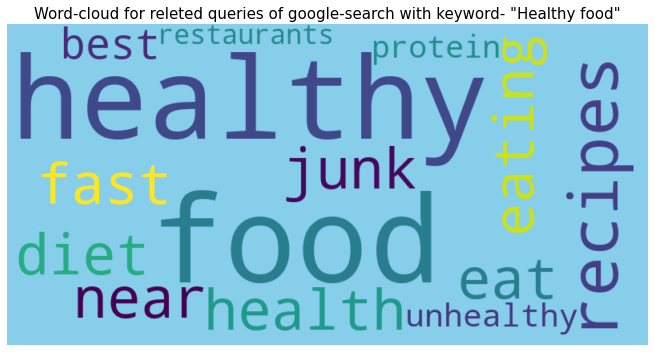

In [545]:
def cleanText(text):
      text= re.sub(r'@[A-Za-z0-9]+', '',text) # Removed @mentions
      text= re.sub(r'#', '',text) # the '#' symbol
      text= re.sub(r':', '',text) # the ':' symbol
      text= re.sub(r'RT[\s]+', '',text) # Removed RT
      text= re.sub(r'https?:\/\/\s+', '',text) # Removed the hyper link
      return text
      
#Function for word-cloud
def wordcloud_plot(releted_queries, title):
  #lets clean the xext first
  releted_queries["query"]= releted_queries["query"].apply(cleanText)
  # Create stopword list
  final_stopwords.update(['https', 'er', 'og', 't', 'co', 'A', 't','The'])
  
  plt.figure(figsize=(10,5))
  allWords= ' '.join( [twts for twts in releted_queries["query"]] )
  wordcloud = WordCloud(stopwords=final_stopwords, max_words=300, width= 800, height=400, random_state=21, max_font_size= 150, background_color="skyblue").generate(allWords)
  
  plt.imshow(wordcloud, interpolation = "bilinear")
  plt.title(title, fontsize=15)
  plt.axis('off')
  plt.tight_layout()
  plt.show()

wordcloud_plot(releted_queries, f'Word-cloud for releted queries of google-search with keyword- "{kw_list[0]}"')

**Trending topics of the year**

In [534]:
# Function for topics of the year
def gt_topics_ofthe_year():
  trends= gt_playload()
  df= pd.DataFrame()# Empty dataframe
  # loop over the year to extract data for each year and put in dataframe as columns
  for year in range(2004, 2022):
      trending = trends.top_charts(year, hl= "en-US", tz=300, geo= "GLOBAL")
      df[year]= trending.title     
  return df.iloc[:, :9].head(5)

gt_topics_ofthe_year()

,2004,2005,2006,2007,2008,2009,2010,2011,2012
0,Ferrari,iPod,Aaron Spelling,American Idol,Joe The Plumber,Michael Jackson,iPad,Amazon Kindle Fire,Southwest Airlines
1,BMW,Digital Camera,Kirby Puckett,YouTube,Jeremiah Wright,Transformers,iPhone 4,iPhone 4s,United Airlines
2,Lamborghini,MP3 Player,Jack Wild,Britney Spears,Maverick,Eminem,Nokia 5530,Sidekick 4g,American Airlines
3,Nissan Skyline,iPod Mini,Clifford Geertz,2007 Cricket World Cup,William Ayers,Naruto Shippuden,HTC EVO 4g,Hp Touchpad,Delta Airlines
4,Porsche,PlayStation Portable,Muriel Spark,Chris Benoit,Bridge To Nowhere,Beyoncé,Nokia N900,Spb Shell 3d,Air France


**Trending Searches (latest trending searches) in a Specific Country**
---
*It highlight stories that are trending across Google surfaces within the last 24 hours and are updated in real-time*

-The` "pn"` argument specifies the geographical location, the name of country in small letter.

In [543]:
# Functing to get latest trending searches
def latest_trending_searches(country_list):
  df_trends= pd.DataFrame()# Empty dataframe
  for country in country_list:
    df_trends[country] = trends.trending_searches(pn=country)
  return df_trends.head(5)

latest_trending_searches(["denmark", "united_states", "sweden", "india"])

,denmark,united_states,sweden,india
0,Jonas Vingegaard,Hurricane Ian tracker,Nord Stream,World Tourism Day
1,Baltic Pipe,Cowboys,Bob Dylan,Navratri Day 2
2,Giorgia Meloni,Jupiter,Riksdagens öppnande,Akshay Kumar Ram Setu
3,NASA,NASA,Mikael Ymer,Jupiter
4,Robbie Williams,Myles Garrett,Per Karlsson,Supreme Court live streaming


#Realtime Search Trends
**- Country code in CAPITAL**

- *Realtime Search Trends highlight stories that are trending across Google surfaces within the last 24 hours, and are updated in realtime.*

In [542]:
# Function for Realtime Search Trends
def realtime_search_trends(country_dict):
  trends= gt_playload()
  df_trends= pd.DataFrame()# Empty dataframe

  for country_key, country_val in country_dict.items():
    df_trends[country_val] = trends.realtime_trending_searches(pn=country_key)["title"]
    
  return df_trends.head(10)

country_dict= {"US":"United_State", "RU":"Russia", "SE":"Sweden", "DE":"Germeny"}
realtime_search_trends(country_dict)
#trends.realtime_trending_searches(pn="US")["title"]

,United_State,Russia,Sweden,Germeny
0,"Ecuador national football team, Japan, 2022","Boris Moiseev, Russia","Slottsskogen, Gothenburg","Accident, Königsbronn, Oberkochen, Carl Zeiss AG"
1,"WE Fest, 2023, Kane Brown, Brad Paisley, Soo P...","Nord Stream, military sabotage, gas pipeline, ...","Mikael Ymer, ATP Tour, Davis Cup","Breakfast at Tiffany's, Holly Golightly, Audre..."
2,"Brittney Griner, WNBA, Russia, Kim Mulkey","Salavat Yulaev Ufa, Kontinental Hockey League,...","The Last of Us, HBO, Pedro Pascal, Ellie","Fertilizer, Natural gas"
3,"Monday Night Football, New York Giants, Dallas...","South Korea national football team, Cameroon, ...","Melodifestivalen, Farah Abadi, Jesper Rönndahl...","Jale İnan, Google, Archaeologist, Doodle"
4,"Putnam County, Palatka, Emergency evacuation, ...","Dina Averina, Olympic Games, Rhythmic gymnastics","Swedish National Audit Office, Government of S...","Charlene, Princess of Monaco, Albert II, Princ..."
5,"Delray Beach, Florida, Palm Beach County","Sweden, Sveriges Television, Explosion, Nord S...","UEFA Nations League, Spain, Spain national foo...","Alan Rickman, Professor Severus Snape, Harry P..."
6,"Ken Paxton, Texas Attorney General, Subpoena","Alec Baldwin, Hilaria Baldwin, Kim Basinger","Shinzo Abe, Japan","Konny Reimann, Die Reimanns - Ein außergewöhnl..."
7,"Asteroid, NASA, Double Asteroid Redirection Te...","Dick Advocaat, FC Zenit, Russia national footb...","Finland national football team, UEFA Nations L...","Portugal national football team, UEFA Nations ..."
8,"Myrtle Beach, WMBF-TV, Long Bay","The Last of Us, HBO, Bella Ramsey, Pedro Pascal","Victoria, Crown Princess of Sweden, Riksmötet-...","Melanie Müller, Nazism, Nazi salute, Far-right..."
9,"Durable good, United States Dollar, Goods","UEFA Nations League, Portugal national footbal...","Vision, Veronica Karlsson, Welfare in Sweden","Alisher Usmanov, Business oligarch, Yacht, Dil..."
